In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

import os
for dirname, _, filenames in os.walk('/kaggle/input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# 한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('F:/data/riiid-test-answer-prediction/train.csv', nrows=10**7)
test = pd.read_csv("F:/data/riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("F:/data/riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("F:/data/riiid-test-answer-prediction/questions.csv")

In [4]:
# train = pd.read_csv('riiid-test-answer-prediction/train.csv', nrows=10**4)
# test = pd.read_csv("riiid-test-answer-prediction/example_test.csv")
# lectures = pd.read_csv("riiid-test-answer-prediction/lectures.csv")
# questions = pd.read_csv("riiid-test-answer-prediction/questions.csv")

In [5]:
# train = pd.read_csv('D:/Project_dataset/Pr_riid//train.csv', nrows=10**4)
# test = pd.read_csv("D:/Project_dataset/Pr_riid/example_test.csv")
# lectures = pd.read_csv("D:/Project_dataset/Pr_riid/lectures.csv")
# questions = pd.read_csv("D:/Project_dataset/Pr_riid/questions.csv")

In [6]:
'''
lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
part: top level category code for the lecture.
tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
type_of: brief description of the core purpose of the lecture
'''

'\nlecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).\npart: top level category code for the lecture.\ntag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.\ntype_of: brief description of the core purpose of the lecture\n'

In [7]:
# lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
# 각각의 강의번호 (train/test에 있는 content_id의 외래키)

lectures.lecture_id.nunique() # 418개의 강의

418

In [8]:
# part: top level category code for the lecture.
#part : 단원
lectures.part.unique()


array([5, 1, 6, 2, 7, 3, 4], dtype=int64)

In [9]:
lectures.part.value_counts() 

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [10]:
lectures.tag

0      159
1       70
2       45
3       79
4      156
      ... 
413      8
414    113
415     24
416    142
417     82
Name: tag, Length: 418, dtype: int64

In [11]:
# tag: one tag codes for the lecture. The meaning of the tags will not be provided, 
#      but these codes are sufficient for clustering the lectures together.
# 강의를 위한 코드 넘버링

lectures[lectures.tag==40]


,lecture_id,tag,part,type_of
202,16736,40,1,concept
215,17649,40,1,solving question


In [12]:
# type_of: brief description of the core purpose of the lecture

lectures.type_of.value_counts()


concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [13]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [14]:
print(f'There are {lectures.shape[0]} lecture_ids.')

There are 418 lecture_ids.


In [21]:
font1 = {'weight': 'bold',
         'size': 14
         }

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}

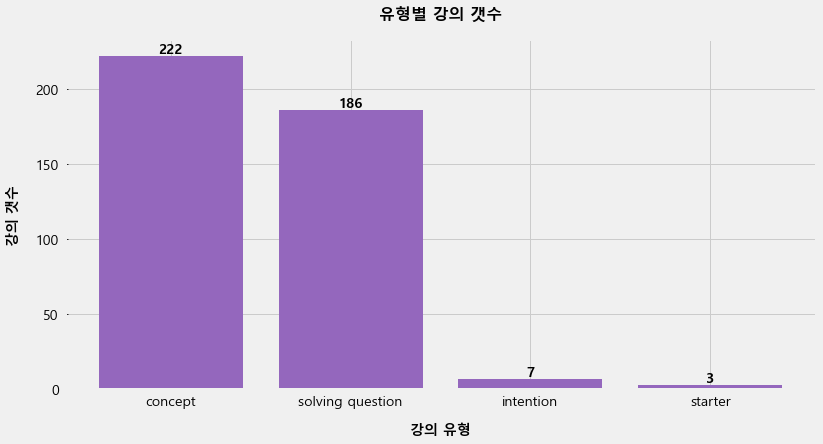

In [23]:
#강의 종류와 갯수 확인 (concept:222  solving question:86  intention:7  starter:3 )

lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values, color='#9467bd')
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("유형별 강의 갯수", fontdict=title_font, pad=20) #강의 종류와 강의 갯수
plt.xlabel("강의 유형", labelpad=15, fontdict=font1) #종류
plt.ylabel("강의 갯수", labelpad=15, fontdict=font1) #이거 삭제해도될듯 # 수
plt.xticks(rotation=0)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)

plt.show()

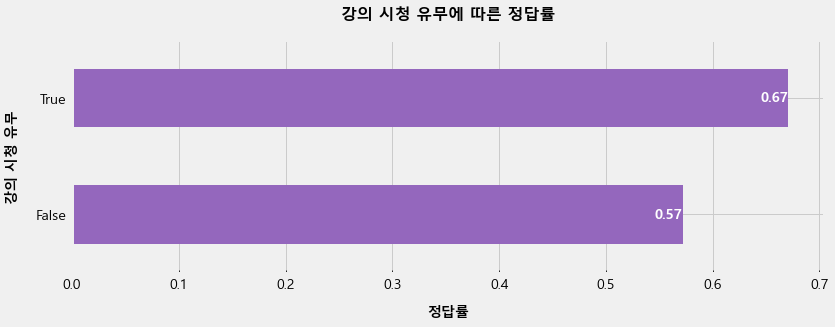

In [24]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
#print(user_lect) # answered_correctly (-1, 0, 1)이 칼럼이 됨

user_lect.columns = ['Lecture', 'Wrong', 'Right'] #칼럼명 지정
user_lect['Lecture'] = user_lect['Lecture'].fillna(0) #-1값이 없는 사람(강의를 한번도 안들은 사람)은 값이 NaN이므로 0으로 채워줌
user_lect = user_lect.astype('Int64') #float -> int
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False) # user_lect.Lecture:강의를 들은 횟수 나타냄
                                        #user_lect.Lecture가 0보다 크면(강의를 1회 이상 들었으면) True, 아니면 False
                                #np.where(조건, 조건이 참일때 입력되는 값, 거짓일때 입력되는값)
#print(user_lect.Lecture)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']}) #틀린문제, 맞은문제 sum
#print(watches_l)

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)
                            #강의안들은사람, 들은사람 각각 맞은문제/전체문제 (맞은문제의비율) 구해서 새로운 칼럼(Percent_correct)으로 추가
#print(watches_l['Percent_correct']) #False:0.572016   True:0.670602

watches_l = watches_l.iloc[:,2] #watches_l의 칼럼 Wrong, Right, Percent_correct 중에 Percent_correct 만 가져옴

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh(color='#9467bd')
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("강의 시청 유무에 따른 정답률", fontdict=title_font, pad=20) # 강의 시청 유무에 따른 정답률
plt.xlabel("정답률", labelpad=15, fontdict=font1) #정답률
plt.ylabel("강의 시청 유무", labelpad=15, fontdict=font1) # 강의 시청 유무
plt.xticks(rotation=0)
plt.tick_params(axis='both', direction='in', length=3, pad=6, labelsize=14)

plt.show()

In [17]:
train.task_container_id

0            1
1            2
2            0
3            3
4            4
          ... 
9999995    410
9999996    411
9999997    412
9999998    413
9999999    414
Name: task_container_id, Length: 10000000, dtype: int64

In [18]:
#추가 분석 필요

batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
print(batch_lect)

batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

answered_correctly   -1        0        1
task_container_id                        
0                   7.0  12660.0  27023.0
1                   1.0  18718.0  20986.0
2                   4.0  22347.0  17294.0
3                   3.0  18081.0  21568.0
4                   4.0  35906.0  33348.0
...                 ...      ...      ...
9995                NaN      5.0     10.0
9996                1.0      1.0     13.0
9997                NaN      3.0     10.0
9998                1.0      2.0     10.0
9999                NaN      4.0      9.0

[10000 rows x 3 columns]
The highest number of lectures watched within a single task_container_id is 523.


In [19]:
batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect

answered_correctly,-1,0,1
task_container_id,,,
0,7.0,12660.0,27023.0
1,1.0,18718.0,20986.0
2,4.0,22347.0,17294.0
3,3.0,18081.0,21568.0
4,4.0,35906.0,33348.0
...,...,...,...
9995,NaN,5.0,10.0
9996,1.0,1.0,13.0
9997,NaN,3.0,10.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

import os
for dirname, _, filenames in os.walk('/kaggle/input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#  한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('F:/data/riiid-test-answer-prediction/train.csv', nrows=10**7)
test = pd.read_csv("F:/data/riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("F:/data/riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("F:/data/riiid-test-answer-prediction/questions.csv")

In [5]:
'''
lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
part: top level category code for the lecture.
tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
type_of: brief description of the core purpose of the lecture
'''

'\nlecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).\npart: top level category code for the lecture.\ntag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.\ntype_of: brief description of the core purpose of the lecture\n'

In [6]:
# lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
# 각각의 강의번호 (train/test에 있는 content_id의 외래키)

lectures.lecture_id.nunique() # 418개의 강의

418

In [7]:
# part: top level category code for the lecture.
#part : 단원
lectures.part.unique()

array([5, 1, 6, 2, 7, 3, 4], dtype=int64)

In [8]:
lectures.part.value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [9]:
lectures.tag

0      159
1       70
2       45
3       79
4      156
      ... 
413      8
414    113
415     24
416    142
417     82
Name: tag, Length: 418, dtype: int64

In [10]:

# tag: one tag codes for the lecture. The meaning of the tags will not be provided, 
#      but these codes are sufficient for clustering the lectures together.
# 강의를 위한 코드 넘버링

lectures[lectures.tag==40]

,lecture_id,tag,part,type_of
202,16736,40,1,concept
215,17649,40,1,solving question


In [11]:

# type_of: brief description of the core purpose of the lecture

lectures.type_of.value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [12]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [13]:
print(f'There are {lectures.shape[0]} lecture_ids.')

There are 418 lecture_ids.


In [20]:
font1 = {'weight': 'bold',
         'size': 14
         }

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}

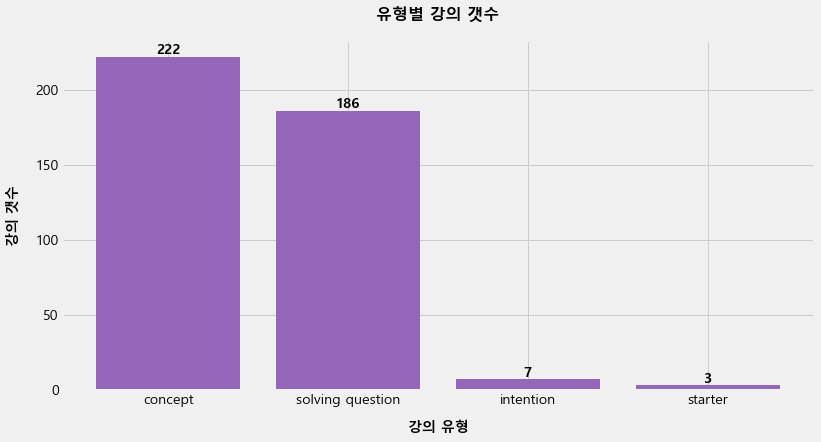

In [21]:
#강의 종류와 갯수 확인 (concept:222  solving question:86  intention:7  starter:3 )

lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values, color='#9467bd')
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("유형별 강의 갯수", fontdict=title_font, pad=20) #강의 종류와 강의 갯수
plt.xlabel("강의 유형", labelpad=15, fontdict=font1) #종류
plt.ylabel("강의 갯수", labelpad=15, fontdict=font1)
plt.xticks(rotation=0)
plt.show()

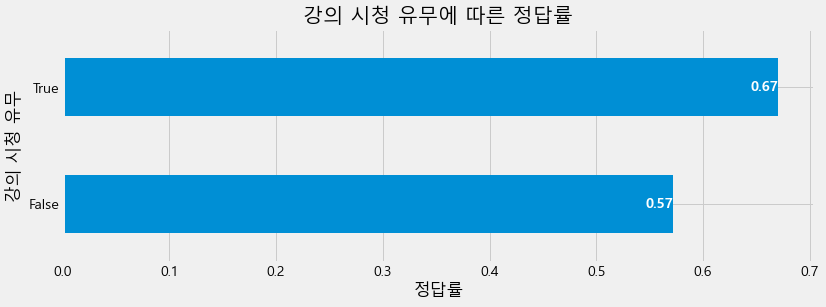

In [15]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
#print(user_lect) # answered_correctly (-1, 0, 1)이 칼럼이 됨

user_lect.columns = ['Lecture', 'Wrong', 'Right'] #칼럼명 지정
user_lect['Lecture'] = user_lect['Lecture'].fillna(0) #-1값이 없는 사람(강의를 한번도 안들은 사람)은 값이 NaN이므로 0으로 채워줌
user_lect = user_lect.astype('Int64') #float -> int
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False) # user_lect.Lecture:강의를 들은 횟수 나타냄
                                        #user_lect.Lecture가 0보다 크면(강의를 1회 이상 들었으면) True, 아니면 False
                                #np.where(조건, 조건이 참일때 입력되는 값, 거짓일때 입력되는값)
#print(user_lect.Lecture)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']}) #틀린문제, 맞은문제 sum
#print(watches_l)

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)
                            #강의안들은사람, 들은사람 각각 맞은문제/전체문제 (맞은문제의비율) 구해서 새로운 칼럼(Percent_correct)으로 추가
#print(watches_l['Percent_correct']) #False:0.572016   True:0.670602

watches_l = watches_l.iloc[:,2] #watches_l의 칼럼 Wrong, Right, Percent_correct 중에 Percent_correct 만 가져옴

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("강의 시청 유무에 따른 정답률") # 강의 시청 유무에 따른 정답률
plt.xlabel("정답률") #정답률
plt.ylabel("강의 시청 유무") # 강의 시청 유무
plt.xticks(rotation=0)
plt.show()

In [20]:
#추가 분석 필요
batch = batch_lect.iloc[:, 3:]

fig = plt.figure(figsize=(12,6))
x = batch.Percent_lecture
y = batch.Percent_correct
plt.scatter(x, y, marker='o')
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent lectures")
plt.ylabel("Percent answered correctly")

plt.show()

AttributeError: 'DataFrame' object has no attribute 'Percent_lecture'

<Figure size 864x432 with 0 Axes>

In [ ]:
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

We have 5979 task_container_ids with lectures and 4021 task_container_ids without lectures.


In [ ]:
batch_lect = batch_lect[['Wrong', 'Right', 'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture").sum()
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect[['Percent_correct']]
batch_lect

,Percent_correct
Has_lecture,
False,0.735944
True,0.656856
